# Modeling

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
import os

import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import joblib

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Define a custom color palette with a single black color
black_palette = sns.color_palette(['black'])

# Set the color palette to the custom palette
sns.set_palette(black_palette)

# Set the Style to Darkgrid
sns.set_style("darkgrid")

In [6]:
# Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'acms80695-384817' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [7]:
# Display the query used to generate the job
job = client.get_job('bquxjob_faada35_188d214ebfc') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT *
FROM `acms80695-384817.Options_Dataset.Clean_Dataset`


In [8]:
# Read results from the job
job = client.get_job('bquxjob_faada35_188d214ebfc') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results.head()

,secid,date,strike_price,impl_volatility,under_price,zero_coupon,div_yield,midpoint,opt_type,time,...,under_lag11,under_lag12,under_lag13,under_lag14,under_lag15,under_lag16,under_lag17,under_lag18,under_lag19,under_lag20
0,113079,2008-04-25,157.5,0.340807,152.550000000,3.784426,2.005183,15.5000,0,0.405202,...,144.850000000,142.710000000,146.210000000,147.460000000,149.690000000,149.910000000,151.250000000,149.290000000,141.950000000,139.610000000
1,102466,1998-07-01,27.5,0.182090,29.409990000,5.843155,5.398922,1.9375,0,2.461328,...,29.099990000,29.200000000,29.340000000,29.379990000,29.259990000,29.099990000,29.200000000,29.239990000,29.019990000,29.049990000
2,102469,1999-07-14,30.0,0.272324,30.939990000,6.189395,0.508508,1.4375,0,0.429843,...,28.819990000,29.109990000,29.429990000,29.929990000,29.620000000,29.799990000,30.500000000,30.399990000,30.439990000,30.640000000
3,102471,1999-05-24,67.5,0.528840,72.459990000,5.881349,10.894450,15.5625,1,1.566051,...,76.500000000,76.739990000,76.739990000,75.789990000,76.450000000,75.219990000,76.030000000,77.099990000,79.489990000,79.329990000
4,108656,1997-07-30,565.0,0.216350,579.339800000,6.182924,0.291477,29.0000,1,0.142368,...,555.919900000,552.490000000,550.539800000,545.689900000,543.099900000,545.349900000,542.359900000,542.029800000,539.039800000,536.189900000


# Preliminary Functions

In [9]:
# This function takes a pandas DataFrame as input.
# It converts specific columns to float datatype if they exist in the DataFrame.
# The list of columns to convert includes 'strike_price', 'impl_volatility', 'under_price',
# 'zero_coupon', 'div_yield', 'midpoint', 'opt_type', 'time', and 'under_lag' columns from 1 to 20.
# The function returns the DataFrame with the converted columns.
def convert_to_float(df):
    columns_to_convert = [
        'strike_price',
        'impl_volatility',
        'under_price',
        'zero_coupon',
        'div_yield',
        'midpoint',
        'opt_type',
        'time',
    ] + [f'under_lag{i}' for i in range(1, 21)]

    for column in columns_to_convert:
        if column in df.columns:
            df[column] = df[column].astype(float)

    return df

In [10]:
# This Function Preprocesses the data for the Black-Scholes Model.
# This Function shuffles the rows, drops columns that will not be used,
# and splits the datasets into training, testing, and validation datasets
# on a 98-1-1 split. This function returns training, validation, and
# testing datasets.
def preprocess_black_scholes(df):
  # Convert selected columns to float type
  # using recently defined function
  df = convert_to_float(results)

  # Shuffle Rows
  data = df.sample(frac=1, random_state=42).reset_index(drop=True)
  # Drop Columns that will not be used
  data = data.drop(['secid', 'date'], axis=1)

  # Calculate indices for the splits
  train_idx = int(0.98 * len(data))
  val_idx = int(0.99 * len(data))
  # Split the data into Training, Validation, and Test Sets
  train_data = data.iloc[:train_idx]
  val_data = data.iloc[train_idx:val_idx]
  test_data = data.iloc[val_idx:]

  return train_data, val_data, test_data

In [11]:
# This Function Runs the Black Scholes Model, makes predictions, and saves the results
# and model statistics in a csv file.
def get_results_black_scholes(test_data):
  bs_results = pd.DataFrame()
  # Calculate Black Scholes Values
  bs_results['Predicted'] = test_data.apply(black_scholes, axis=1)
  # Append True Values to the DataFrames
  bs_results['True'] = test_data['midpoint']

  # Create a Column of the Difference Between the Predicted and True Values
  bs_results['Difference'] = bs_results['Predicted'] - bs_results['True']

  # Create a Column for Absolute Error
  bs_results['Absolute Error'] = abs(bs_results['Difference'])

  # Create a Column for Absolute Percentage Error
  bs_results['Absolute Percentage Error'] = abs(bs_results['Difference'] / bs_results['True']) * 100

  # Drop the Difference Column
  bs_results = bs_results.drop(columns=['Difference'])

  # Sort them by True Values Descending
  bs_results = bs_results.sort_values(by='True', ascending=False)

  # Save the Results to a CSV File
  bs_results.to_csv('bs_results.csv', index=False)

  return bs_results

In [12]:
# This Function is able to display the results for all of the
# models used in this notebook.
def display_results(bs_results):
  # Preview the First 10 Results Sorted by True Values in Descending Order
  print("First 5 Results Sorted by True Values in Descending Order:")
  display(bs_results.head())
  # Preview the Last 10 Results Sorted by True Values in Descending Order
  print("Last 5 Results Sorted by True Values in Descending Order:")
  display(bs_results.tail())
  # Print and Plot the Mean Absolute Error
  print('Mean Absolute Error:', round(bs_results['Absolute Error'].mean(), 2))
  plt.figure()
  sns.scatterplot(x='True', y='Absolute Error', data=bs_results)
  plt.xscale('log')
  plt.yscale('log')
  plt.show()
  print()
  # Print and Plot the Mean Absolute Percentage Error
  print('Mean Absolute Percentage Error:', round(bs_results['Absolute Percentage Error'].mean(), 2), '%')
  # Plot the Absolute Percentage Error
  plt.figure()
  sns.scatterplot(x='True', y='Absolute Percentage Error', data=bs_results)
  plt.xscale('log')
  plt.yscale('log')
  plt.show()

# Model 1: Black Scholes Model

In [13]:
def black_scholes(row):
    # Extract input values from the row
    S = row['under_price']
    K = row['strike_price']
    T = row['time']
    r = row['zero_coupon']/100
    q = row['div_yield']/100
    sigma = row['impl_volatility']/100
    opt_type = row['opt_type']

    # Compute the Black-Scholes option price here
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if opt_type == 1:
        option_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif opt_type == 0:
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    return option_price

First 5 Results Sorted by True Values in Descending Order:


,Predicted,True,Absolute Error,Absolute Percentage Error
10737997,11763.403990,11767.40,3.996010,0.033958
10715639,6111.492235,6124.00,12.507765,0.204242
10646916,5859.112119,5856.15,2.962119,0.050581
10658680,5688.389369,5695.65,7.260631,0.127477
10721190,5668.827104,5668.40,0.427104,0.007535


Last 5 Results Sorted by True Values in Descending Order:


,Predicted,True,Absolute Error,Absolute Percentage Error
10671252,0.0,0.015,0.015,100.0
10699873,0.0,0.015,0.015,100.0
10735287,0.0,0.015,0.015,100.0
10708742,0.0,0.015,0.015,100.0
10694275,0.0,0.015,0.015,100.0


Mean Absolute Error: 24.54


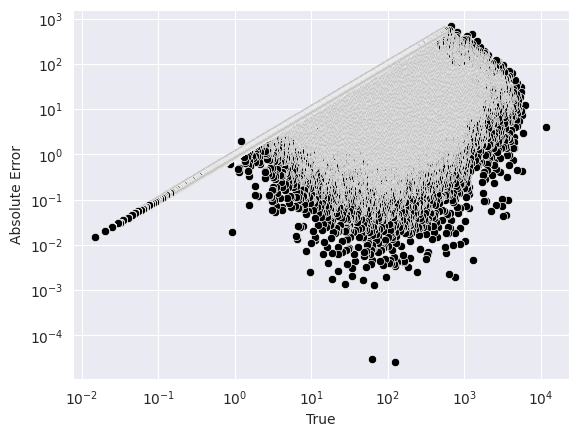


Mean Absolute Percentage Error: 63.65 %


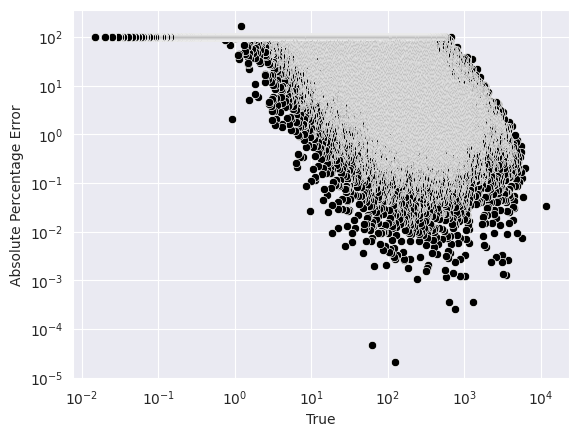

In [14]:
train_data, val_data, test_data = preprocess_black_scholes(results)
model_results = get_results_black_scholes(test_data)
display_results(model_results)

# Switch to TPU Runtime

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# Model 2: 3 Layer Feed Forward Neural Network

# Model 3: 4 Layer Feed Forward Neural Network

# Model 4: 5 Layer Feed Forward Neural Network

# Switch to GPU Runtime

# Model 5: XGBoost with Max Depth of 5

# Model 6: XGBoost with Max Depth of 10

# Model 7: Google AutoML

# Results

In [17]:
# Results